In [45]:
import re
import pandas as df
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [46]:
OSFXtest = df.read_csv('partitions/OSFXtest.csv')
OSFytest = df.read_csv('partitions/OSFytest.csv')

combinedTest = df.read_csv('partitions/test.csv')
combinedXtest = combinedTest.drop(columns="Generated")
combinedYtest = combinedTest.drop(columns="Review")

In [47]:
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
def processWord(word):
    return re.sub(r'\W+', '', word)

def tokenize(x, y, onehot_dict):
    tokenized_x = [[onehot_dict[processWord(word)] for word in str(sentence).lower().split() if processWord(word) in onehot_dict] for sentence in x['Review'].values]

    encoded_y = [1 if generation_status == 1 else 0 for generation_status in y['Generated'].values]
    return np.array(tokenized_x), np.array(encoded_y)

## Encode in different manners

In [49]:
import pickle
# Create onehot dictionaries for input on all 4 models
with open("osf_onehot.pkl","rb") as file:
    osf_onehot_dict = pickle.load(file)
with open("imbalanced_onehot.pkl","rb") as file:
    imbalanced_onehot_dict = pickle.load(file)
with open("oversampled_onehot.pkl","rb") as file:
    oversampled_onehot_dict = pickle.load(file)
with open("undersampled_onehot.pkl","rb") as file:
    undersampled_onehot_dict = pickle.load(file)
    
# Input for OSF model to test on combined imbalanced dataset
osf_combinedXtest_input, osf_combinedYtest_input = tokenize(combinedXtest, combinedYtest, osf_onehot_dict)
# Input for Imbalanced model to test on combined imbalanced dataset
imbalanced_combinedXtest_input, imbalanced_combinedYtest_input = tokenize(combinedXtest, combinedYtest, imbalanced_onehot_dict)
# Input for Oversampled model to test on combined imbalanced dataset
oversampled_combinedXtest_input, oversampled_combinedYtest_input = tokenize(combinedXtest, combinedYtest, oversampled_onehot_dict)
# Input for Undersampled model to test on combined imbalanced dataest
undersampled_combinedXtest_input, undersampled_combinedYtest_input = tokenize(combinedXtest, combinedYtest, undersampled_onehot_dict)

# Input for OSF model on OSF dataset
osf_OSFXtest, osf_OSFYtest = tokenize(OSFXtest, OSFytest, osf_onehot_dict)
# Input for Imbalanced model to test on OSF dataset
imbalanced_OSFXtest, imbalanced_OSFYtest = tokenize(OSFXtest, OSFytest, imbalanced_onehot_dict)
# Input for Oversampled model to test on OSF dataset
oversampled_OSFXtest, oversampled_OSFYtest = tokenize(OSFXtest, OSFytest, oversampled_onehot_dict)
# Input for imbalanced model to test on OSF dataset
undersampled_OSFXtest, undersampled_OSFYtest = tokenize(OSFXtest, OSFytest, undersampled_onehot_dict)

C:\Users\John\AppData\Local\Temp\ipykernel_7208\3540215665.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(tokenized_x), np.array(encoded_y)


## Pad Vectors

In [50]:
def padVectors(sentences, length):
    vectors = np.zeros((len(sentences), length), dtype=int)
    for i, sentence in enumerate(sentences):
        if len(sentence) != 0:
            l = min(length, len(sentence))
            vectors[i, -l:] = np.array(sentence)[:l]
    return vectors

In [51]:
osf_combinedXtest_padded = padVectors(osf_combinedXtest_input, 250)
imbalanced_combinedXtest_padded = padVectors(imbalanced_combinedXtest_input, 250)
oversampled_combinedXtest_padded = padVectors(oversampled_combinedXtest_input, 250)
undersampled_combinedXtest_padded = padVectors(undersampled_combinedXtest_input, 250)

osf_OSFXtest_padded = padVectors(osf_OSFXtest, 250)
imbalanced_OSFXtest_padded = padVectors(imbalanced_OSFXtest, 250)
oversampled_OSFXtest_padded = padVectors(oversampled_OSFXtest, 250)
undersampled_OSFXtest_padded = padVectors(undersampled_OSFXtest, 250)

## Create Dataloaders

In [52]:
osf_combined = torch.utils.data.TensorDataset(torch.from_numpy(osf_combinedXtest_padded), torch.from_numpy(osf_combinedYtest_input))
imbalanced_combined = torch.utils.data.TensorDataset(torch.from_numpy(imbalanced_combinedXtest_padded), torch.from_numpy(imbalanced_combinedYtest_input))
oversampled_combined = torch.utils.data.TensorDataset(torch.from_numpy(oversampled_combinedXtest_padded), torch.from_numpy(oversampled_combinedYtest_input))
undersampled_combined = torch.utils.data.TensorDataset(torch.from_numpy(undersampled_combinedXtest_padded), torch.from_numpy(undersampled_combinedYtest_input))

osf_OSF = torch.utils.data.TensorDataset(torch.from_numpy(osf_OSFXtest_padded), torch.from_numpy(osf_OSFYtest))
imbalanced_OSF = torch.utils.data.TensorDataset(torch.from_numpy(imbalanced_OSFXtest_padded), torch.from_numpy(imbalanced_OSFYtest))
oversampled_OSF = torch.utils.data.TensorDataset(torch.from_numpy(oversampled_OSFXtest_padded), torch.from_numpy(oversampled_OSFYtest))
undersampled_OSF = torch.utils.data.TensorDataset(torch.from_numpy(undersampled_OSFXtest_padded), torch.from_numpy(undersampled_OSFYtest))

# batch size for dataloaders
BATCH_SIZE = 64

osf_combined_loader = torch.utils.data.DataLoader(osf_combined, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
imbalanced_combined_loader = torch.utils.data.DataLoader(imbalanced_combined, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
oversampled_combined_loader = torch.utils.data.DataLoader(oversampled_combined, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
undersampled_combined_loader = torch.utils.data.DataLoader(undersampled_combined, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

osf_OSF_loader = torch.utils.data.DataLoader(osf_OSF, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
imbalanced_OSF_loader = torch.utils.data.DataLoader(imbalanced_OSF, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
oversampled_OSF_loader = torch.utils.data.DataLoader(oversampled_OSF, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
undersampled_OSF_loader = torch.utils.data.DataLoader(undersampled_OSF, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

In [53]:
class ReviewClassifier(nn.Module):
    def __init__(self,vocab_size,embedding_dim, hidden_dim):
        super(ReviewClassifier,self).__init__()
        
        self.hidden_dim = hidden_dim
        self.no_layers = 1
    
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=1,
                            batch_first=True)
        
        self.fc = nn.Linear(self.hidden_dim, 1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        
        # embedding layer
        embeds = self.embedding(x) 
        
        # LSTM layer
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # fully connected layer
        out = self.fc(lstm_out)
        
        # sigmoid function
        sig_out = self.sigmoid(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        # create zero tensors for the hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        return (h0,c0)

In [54]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [55]:
criterion = nn.BCELoss()

def acc(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [57]:
def return_misses(inputs, output, labels, vocab):
    pred = torch.round(output.squeeze())
    labels = labels.squeeze()
    misses = []
    false_negative = 0
    false_positive = 0
    for i in range(len(pred)):
        if pred[i] != labels[i]:
            if pred[i] == 0:
                false_positive += 1
            else:
                false_negative += 1
        misses.append(' '.join([vocab[inputs[i][j].item()] for j in range(len(inputs[i])) if inputs[i][j].item() != 0]))
    return misses, false_negative, false_positive

def do_test_stats(vocabulary, test_loader):
    test_h = model.init_hidden(BATCH_SIZE)
    test_losses = []
    test_acc = 0.0
    tot_misses = []
    model.eval()
    vocab_r = {v: k for k, v in vocabulary.items()}
    false_positives = 0
    false_negatives = 0
    tot_outputs = 0
    tot_labels = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            test_h = tuple([each.data for each in test_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, test_h = model(inputs, test_h)
            test_loss = criterion(output.squeeze(), labels.float())

            test_losses.append(test_loss.item())
            misses, fneg, fpos = return_misses(inputs, output, labels, vocab_r)
            tot_misses.extend(misses)
            false_positives += fpos
            false_negatives += fneg
            accuracy = acc(output,labels)
            test_acc += accuracy

            tot_outputs = output if type(tot_outputs) == type(0) else torch.cat((tot_outputs, output))
            tot_labels = labels if type(tot_labels) == type(0) else torch.cat((tot_labels, labels))

    test_loss = np.mean(test_losses)
    test_acc = test_acc/len(test_loader.dataset)
    false_positive_rate = false_positives / len(test_loader.dataset)
    false_negative_rate = false_negatives / len(test_loader.dataset)
    print(f'test_loss : {test_loss}')
    print(f'test_accuracy : {test_acc*100}')
    print(f'false_positive : {false_positives / len(test_loader.dataset)} ')
    print(f'false_negatives : {false_negatives / len(test_loader.dataset)} ')
    return tot_outputs, tot_labels, [test_loss, test_acc, false_positive_rate, false_negative_rate]
    
def display_confusion_matrix(tot_outputs, tot_labels):
    cm = confusion_matrix(tot_labels.cpu().data.numpy(), torch.round(tot_outputs.squeeze()).cpu().data.numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

## Run models on OSF dataset

### Model trained on OSF dataset 

In [100]:
vocabulary_size = len(osf_onehot_dict)+1
embedding_dim = 64
hidden_dim = 256

In [101]:
model = ReviewClassifier(vocabulary_size, embedding_dim, hidden_dim)
model.load_state_dict(torch.load("best_loss_OSF_state_dict.pt"))
model.to(device)
model.eval()

ReviewClassifier(
  (embedding): Embedding(45687, 64)
  (lstm): LSTM(64, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [102]:
osf_OSF_tot_outputs, osf_OSF_tot_labels, osf_OSF_data = do_test_stats(osf_onehot_dict, osf_OSF_loader)


test_loss : 0.25322758838061304
test_accuracy : 89.55113144552986
false_positive : 0.05688141461605045 
false_negatives : 0.0447632001978484 


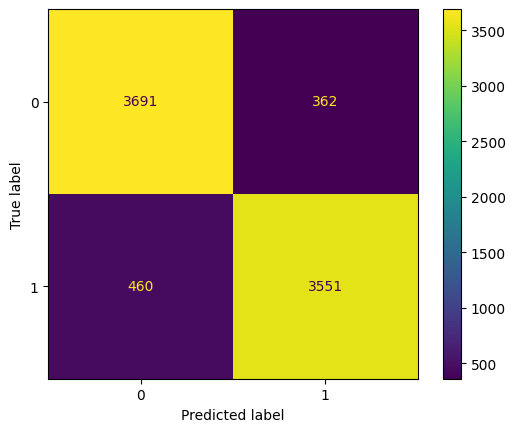

In [103]:
display_confusion_matrix(osf_OSF_tot_outputs, osf_OSF_tot_labels)

### Model trained on Imbalanced Combined Dataset

In [87]:
vocabulary_size = len(imbalanced_onehot_dict)+1

In [88]:
model = ReviewClassifier(vocabulary_size, embedding_dim, hidden_dim)
model.load_state_dict(torch.load("best_loss_imbalanced_state_dict.pt"))
model.to(device)
model.eval()

ReviewClassifier(
  (embedding): Embedding(277633, 64)
  (lstm): LSTM(64, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [89]:
osf_imbalanced_tot_outputs, osf_imbalanced_tot_labels, osf_imbalanced_data = do_test_stats(imbalanced_onehot_dict, imbalanced_OSF_loader)

test_loss : 0.2990203558925598
test_accuracy : 88.16619265487819
false_positive : 0.04488685544701373 
false_negatives : 0.07060714727340175 


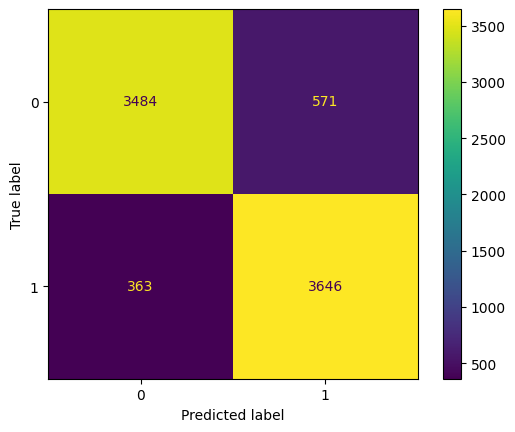

In [90]:
display_confusion_matrix(osf_imbalanced_tot_outputs, osf_imbalanced_tot_labels)

### Model trained on Oversampled Combined Dataset

In [91]:
vocabulary_size = len(oversampled_onehot_dict)+1

In [92]:
model = ReviewClassifier(vocabulary_size, embedding_dim, hidden_dim)
model.load_state_dict(torch.load("best_loss_oversampled_state_dict.pt"))
model.to(device)
model.eval()

ReviewClassifier(
  (embedding): Embedding(290102, 64)
  (lstm): LSTM(64, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [93]:
osf_oversampled_tot_outputs, osf_oversampled_tot_labels, osf_oversampled_data = do_test_stats(oversampled_onehot_dict, oversampled_OSF_loader)

test_loss : 0.28307056258476915
test_accuracy : 91.43069123284283
false_positive : 0.07753184122666007 
false_negatives : 0.005317175714109064 


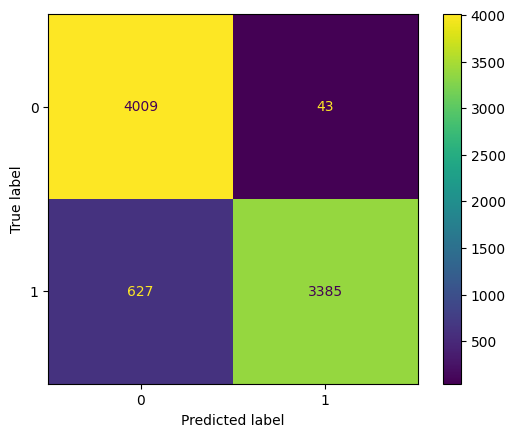

In [94]:
display_confusion_matrix(osf_oversampled_tot_outputs, osf_oversampled_tot_labels)

### Model Trained on Undersampled Combined Dataset

In [95]:
vocabulary_size = len(undersampled_onehot_dict)+1

In [96]:
model = ReviewClassifier(vocabulary_size, embedding_dim, hidden_dim)
model.load_state_dict(torch.load("best_loss_undersampled_state_dict.pt"))
model.to(device)
model.eval()

ReviewClassifier(
  (embedding): Embedding(125382, 64)
  (lstm): LSTM(64, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [97]:
osf_undersampled_tot_outputs, osf_undersampled_tot_labels, osf_undersampled_data = do_test_stats(undersampled_onehot_dict, undersampled_OSF_loader)

test_loss : 0.573227702625214
test_accuracy : 68.02275256584642
false_positive : 0.30542846543835783 
false_negatives : 0.011499938172375417 


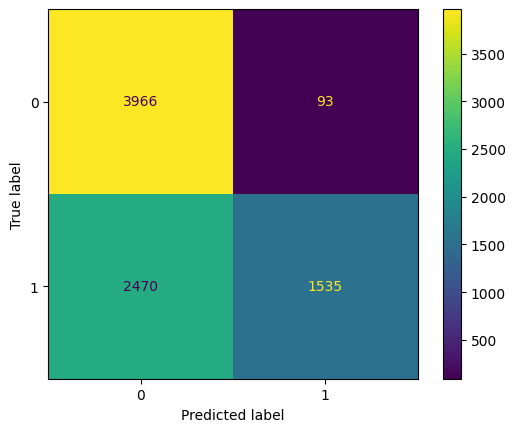

In [98]:
display_confusion_matrix(osf_undersampled_tot_outputs, osf_undersampled_tot_labels)

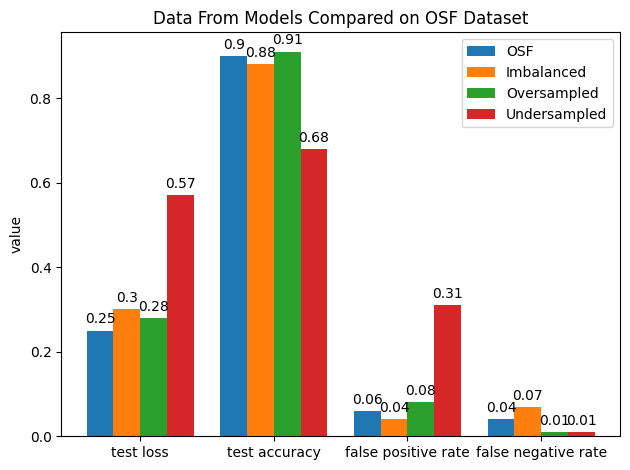

In [104]:
labels = ["test loss", "test accuracy", "false positive rate", "false negative rate"]
x = np.arange(len(labels))
width = 0.2

osf_OSF_data = [round(n,2) for n in osf_OSF_data]
osf_imbalanced_data = [round(n,2) for n in osf_imbalanced_data]
osf_oversampled_data = [round(n,2) for n in osf_oversampled_data]
osf_undersampled_data = [round(n,2) for n in osf_undersampled_data]


fig, ax = plt.subplots()
rects1 = ax.bar(x - 3/2*width, osf_OSF_data, width, label = "OSF")
rects2 = ax.bar(x - 1/2*width, osf_imbalanced_data, width, label = "Imbalanced")
rects3 = ax.bar(x + 1/2*width, osf_oversampled_data, width, label = "Oversampled")
rects4 = ax.bar(x + 3/2*width, osf_undersampled_data, width, label = "Undersampled")

ax.set_ylabel("value")
ax.set_title("Data From Models Compared on OSF Dataset")
ax.set_xticks(x, labels)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)
ax.legend()

fig.tight_layout()

plt.show()

## Run Models on Imbalanced Combined Test Dataset

### Model trained on OSF Dataset

In [105]:
vocabulary_size = len(osf_onehot_dict)+1
embedding_dim = 64
hidden_dim = 256

In [106]:
model = ReviewClassifier(vocabulary_size, embedding_dim, hidden_dim)
model.load_state_dict(torch.load("best_loss_OSF_state_dict.pt"))
model.to(device)
model.eval()

ReviewClassifier(
  (embedding): Embedding(45687, 64)
  (lstm): LSTM(64, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [107]:
combined_OSF_tot_outputs, combined_OSF_tot_labels, combined_OSF_data = do_test_stats(osf_onehot_dict, osf_combined_loader)

test_loss : 0.7863477954211143
test_accuracy : 85.6670724003513
false_positive : 0.021601466804307967 
false_negatives : 0.12161995593424033 


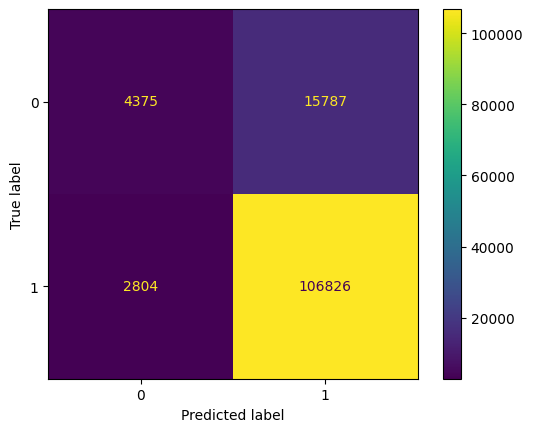

In [108]:
display_confusion_matrix(combined_OSF_tot_outputs, combined_OSF_tot_labels)

### Model trained on Imbalanced Combined Dataset

In [109]:
vocabulary_size = len(imbalanced_onehot_dict)+1

In [110]:
model = ReviewClassifier(vocabulary_size, embedding_dim, hidden_dim)
model.load_state_dict(torch.load("best_loss_imbalanced_state_dict.pt"))
model.to(device)
model.eval()

ReviewClassifier(
  (embedding): Embedding(277633, 64)
  (lstm): LSTM(64, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [111]:
combined_imbalanced_tot_outputs, combined_imbalanced_tot_labels, combined_imbalanced_data = do_test_stats(imbalanced_onehot_dict, imbalanced_combined_loader)

test_loss : 0.35432832850477636
test_accuracy : 86.63621096097252
false_positive : 0.006864089487388873 
false_negatives : 0.12666594764494707 


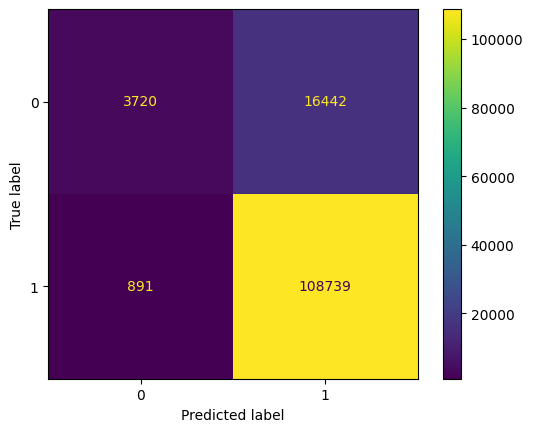

In [112]:
display_confusion_matrix(combined_imbalanced_tot_outputs, combined_imbalanced_tot_labels)

### Model trained on Oversampled Combined Dataset

In [113]:
vocabulary_size = len(oversampled_onehot_dict)+1

In [114]:
model = ReviewClassifier(vocabulary_size, embedding_dim, hidden_dim)
model.load_state_dict(torch.load("best_loss_oversampled_state_dict.pt"))
model.to(device)
model.eval()

ReviewClassifier(
  (embedding): Embedding(290102, 64)
  (lstm): LSTM(64, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [115]:
combined_oversampled_tot_outputs, combined_oversampled_tot_labels, combined_oversampled_data = do_test_stats(oversampled_onehot_dict, oversampled_combined_loader)

test_loss : 0.2940076214189713
test_accuracy : 89.28246768254165
false_positive : 0.09340862517911344 
false_negatives : 0.013658844737531393 


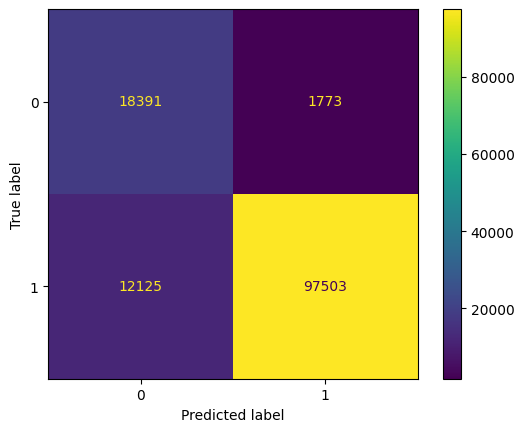

In [116]:
display_confusion_matrix(combined_oversampled_tot_outputs, combined_oversampled_tot_labels)

### Model Trained on Undersampled Combined Dataset

In [117]:
vocabulary_size = len(undersampled_onehot_dict)+1

In [118]:
model = ReviewClassifier(vocabulary_size, embedding_dim, hidden_dim)
model.load_state_dict(torch.load("best_loss_undersampled_state_dict.pt"))
model.to(device)
model.eval()

ReviewClassifier(
  (embedding): Embedding(125382, 64)
  (lstm): LSTM(64, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [119]:
combined_undersampled_tot_outputs, combined_undersampled_tot_labels, combined_undersampled_data = do_test_stats(undersampled_onehot_dict, undersampled_combined_loader)

test_loss : 0.5381573461716227
test_accuracy : 72.26091243856216
false_positive : 0.22503582268924394 
false_negatives : 0.05224719966719566 


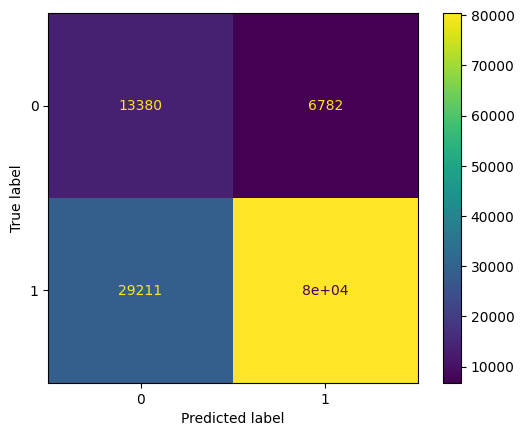

In [120]:
display_confusion_matrix(combined_undersampled_tot_outputs, combined_undersampled_tot_labels)

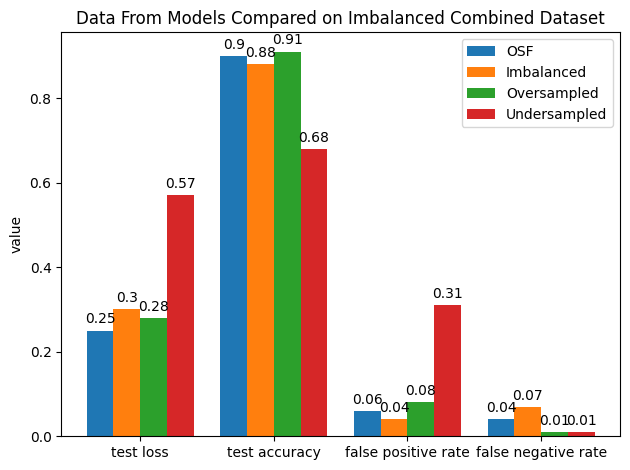

In [121]:
labels = ["test loss", "test accuracy", "false positive rate", "false negative rate"]
x = np.arange(len(labels))
width = 0.2

combined_OSF_data = [round(n,2) for n in combined_OSF_data]
combined_imbalanced_data = [round(n,2) for n in combined_imbalanced_data]
combined_oversampled_data = [round(n,2) for n in combined_oversampled_data]
combined_undersampled_data = [round(n,2) for n in combined_undersampled_data]


fig, ax = plt.subplots()
rects1 = ax.bar(x - 3/2*width, osf_OSF_data, width, label = "OSF")
rects2 = ax.bar(x - 1/2*width, osf_imbalanced_data, width, label = "Imbalanced")
rects3 = ax.bar(x + 1/2*width, osf_oversampled_data, width, label = "Oversampled")
rects4 = ax.bar(x + 3/2*width, osf_undersampled_data, width, label = "Undersampled")

ax.set_ylabel("value")
ax.set_title("Data From Models Compared on Imbalanced Combined Dataset")
ax.set_xticks(x, labels)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)
ax.legend()

fig.tight_layout()

plt.show()